In [1]:
import numpy as np
import cv2 as cv
import os
import math
import faiss

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_sift_keypoints(img, resize_width=1024):
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    dsize = (resize_width, int(gray.shape[0] / (gray.shape[1] / resize_width)))
    gray = cv.resize(gray, dsize)
    # plt.imshow(gray)
    # plt.axis('off')
    # plt.show()
    sift = cv.SIFT_create(nfeatures=1000)
    kp, des = sift.detectAndCompute(gray, None)
    img=cv.drawKeypoints(gray,kp,img)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return kp, des

In [3]:
def create_sift_database():
    labels = []
    features = []
    for image_name in os.listdir('images'):
        if '.jpeg' not in image_name and '.jpg' not in image_name:
            continue
        index_of_dot = image_name.find('.')
        building_name = image_name[0:(index_of_dot - 2)]

        image_path = 'images/' + image_name
        img = cv.imread(image_path)

        kp, des = get_sift_keypoints(img)
        labels += [building_name for i in range(len(kp))]

        features.append(np.vstack(des))
    return labels, features

(416, 1140)
(373, 1024)


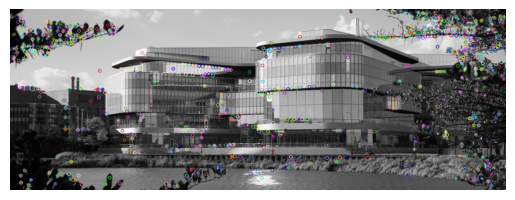

(675, 1200)
(576, 1024)


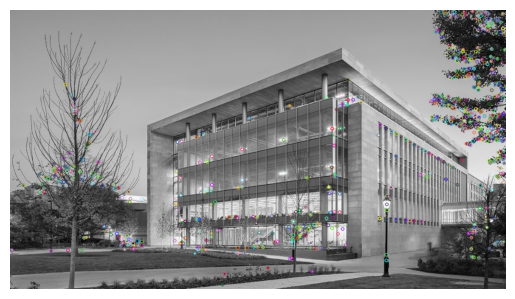

(1020, 1360)
(768, 1024)


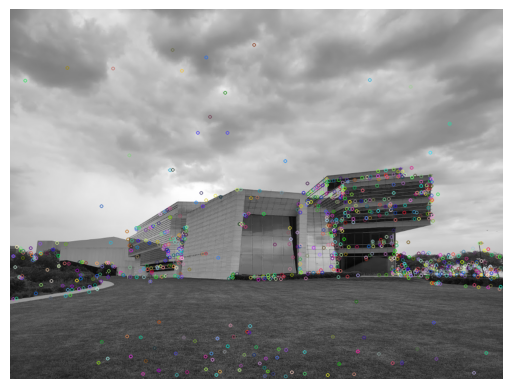

(1449, 3888)
(381, 1024)


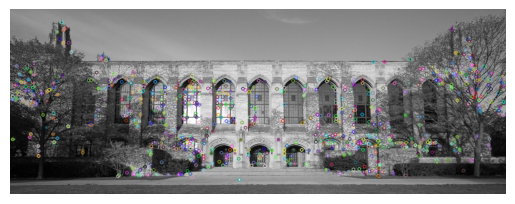

In [4]:
labels, features = create_sift_database()

In [5]:
len(labels)

3966

In [6]:
features_ar = np.vstack(features)
features_ar.shape

(3966, 128)

In [7]:
index = faiss.IndexFlatL2(128)
index.add(features_ar)
print(index.ntotal)

3966


In [8]:
def get_percentage_scores(top_tuple_list, softmax_temp=3):
    # Softmax calculation
    top_list = []
    sum_of_scores = 0
    for score, name in top_tuple_list:
        top_list.append(name)
        sum_of_scores += math.exp(score / softmax_temp)
    percentage_scores = [math.exp(top_tuple_list[i][0] / softmax_temp) * 100 / sum_of_scores for i in range(len(top_tuple_list))]
    return top_list, percentage_scores

In [9]:
def find_closest_image_match(img, k=5, method='sift'):
    if method == 'sift':
        kp, des = get_sift_keypoints(img)
        preds = {}
        for d in des:
            D, I = index.search(d.reshape((1, 128)), k)
            for i, idx in enumerate(I[0]):
                pred = labels[idx]
                if pred not in preds:
                    preds[pred] = 0
                preds[pred] += 1 / (i + 1)
        top_tuple_list = sorted([(v, k) for k, v in preds.items()], reverse=True)
        scores = [top_tuple[0] for top_tuple in top_tuple_list]
        top_tuple_list = [(v-max(scores), k) for v, k in top_tuple_list]
        top_list, percentage_scores = get_percentage_scores(top_tuple_list)
        return top_list, percentage_scores
    elif method == 'surf':
        return None
    else:
        return None

bienen
(500, 870, 3)
(500, 870)
(588, 1024)


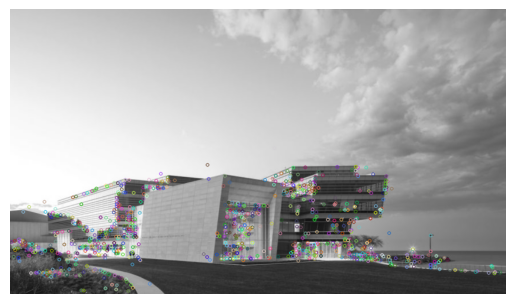

Bienen_School_of_Music with 100.00% confidence
Kellogg with 0.00% confidence
Deering_Library with 0.00% confidence
Mudd_Library with 0.00% confidence

kellogg
(768, 1024, 3)
(768, 1024)
(768, 1024)


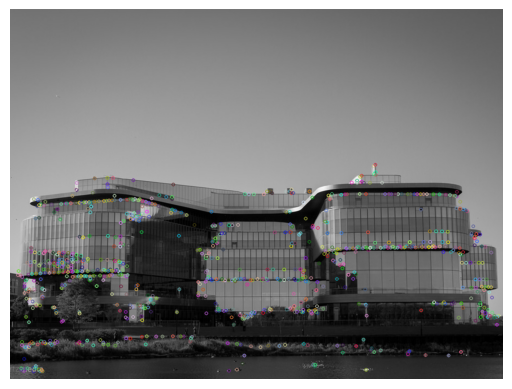

Kellogg with 100.00% confidence
Bienen_School_of_Music with 0.00% confidence
Deering_Library with 0.00% confidence
Mudd_Library with 0.00% confidence

deering
(352, 761, 3)
(352, 761)
(473, 1024)


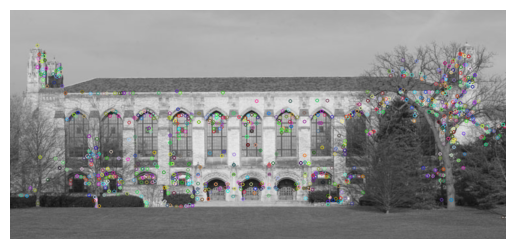

Deering_Library with 100.00% confidence
Kellogg with 0.00% confidence
Mudd_Library with 0.00% confidence
Bienen_School_of_Music with 0.00% confidence



In [10]:
for image_name in os.listdir('search_images'):
    if '.jpeg' not in image_name and '.jpg' not in image_name:
        continue
    index_of_dot = image_name.find('.')
    building_name = image_name[0:index_of_dot]
    image_path = 'search_images/' + image_name
    img = cv.imread(image_path)
    
    print(building_name)
    print(img.shape)
    top_list, percentage_scores = find_closest_image_match(img)
    for i in range(len(top_list)):
        name = top_list[i]
        percentage_score = percentage_scores[i]
        print(f'{name} with {percentage_score:.2f}% confidence')
    print()